In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
from scipy.io import wavfile

In [88]:
folder = './data/'
name = '_2017-11-02 22-48-30_74954260535_209_Ильясова.wav'
sample_rate, signal = wavfile.read(folder + name)

print('{} kHz, {} s'.format(sample_rate, 1. / sample_rate * len(signal)))

8000 kHz, 208.4375 s


In [89]:
pre_emphasis = 0.97
signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

In [90]:
frame_size = 0.03 # seconds
frame_stride = 0.02 # defines overlap between frames
signal_length = len(signal)
frame_length = int(frame_size * sample_rate)
frame_step = int(frame_stride * sample_rate)
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)) 

In [91]:
pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(signal, z)

In [92]:
# framing
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
          np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

In [93]:
%%time
# Fourier & window multiplying
power_spectrum = 1 / frame_length * np.power(np.abs(np.fft.fft(frames * np.hamming(frame_length))), 2)
freq = np.linspace(0, 2 * sample_rate, frame_length) 
time = np.linspace(0, frame_stride * num_frames, num_frames)

CPU times: user 120 ms, sys: 12 ms, total: 132 ms
Wall time: 130 ms


In [94]:
# viewing spectrogram
observing_time = 180  # seconds
observing_freqs = 8  # kHz

times = np.s_[:np.where(time < observing_time)[0][-1]]
freqs = np.s_[:np.where(freq < observing_freqs * 1e3)[0][-1]]

t = time[times]

In [95]:
est_frames = frames[(times, np.s_[:])]

In [96]:
average_power = np.sum(np.power(est_frames, 2), axis=1)
average_power_db = 10 * np.log10(average_power / np.max(average_power))
level = -30

minimum_pause_time = .5  # s
p = int(minimum_pause_time / frame_stride)

In [97]:
# Results of pauses detecting
t = time[times]
spectrogram = np.log10(power_spectrum[(times, freqs)]).T

pauses = (np.convolve(average_power_db < level, np.ones(p), mode='same') == p).astype(int)

def get_pauses_idx(pauses):
    temp = np.hstack((0, np.diff(pauses), 0))
    left = np.where(temp > 0)[0] - 1
    right = np.where(temp < 0)[0] - 1
    return np.hstack((left, right)).reshape(2, -1)
pauses_idx = get_pauses_idx(pauses)
pauses_idx = np.hstack((np.array([-1, 0]).reshape(-1, 1), pauses_idx, np.array([len(pauses), len(pauses) + 1]).reshape(-1, 1)))

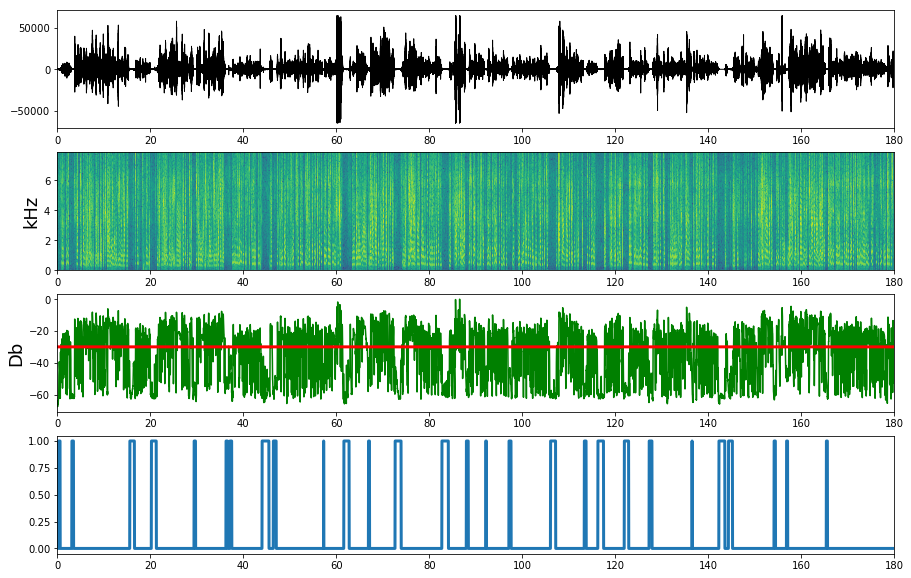

In [98]:
plt.figure(figsize=(15, 10))
plt.subplot(4,1,1)
plt.plot(np.arange(signal[:observing_time * sample_rate].size) / 
         sample_rate, signal[:observing_time * sample_rate], 'k', lw=1)
plt.xlim(np.min(t), np.max(t))
plt.subplot(4,1,2)
plt.pcolor(t, freq[freqs] / 1e3, spectrogram)
plt.ylabel('kHz', fontsize=18)
plt.subplot(4,1,3)
plt.plot(t, average_power_db, 'g')
plt.plot(t, level * np.ones_like(time[times]), 'r', lw=3)
plt.ylabel('Db', fontsize=18)
plt.xlim(np.min(t), np.max(t))
plt.subplot(4,1,4)
plt.plot(t, pauses, lw=3)
plt.xlim(np.min(t), np.max(t))
plt.show()

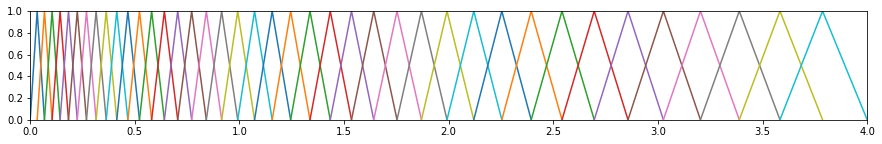

In [99]:
# MEL
nfilt = 40

low_freq_mel= 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10 ** (mel_points / 2595) - 1))  # Convert Mel to Hz
bins = (power_spectrum.shape[1] * hz_points / sample_rate).astype(int)

plt.figure(figsize=(15, 2))
for m in np.arange(1, nfilt + 1):
    f_m_minus = hz_points[m - 1]   # left
    f_m = hz_points[m]             # center
    f_m_plus = hz_points[m + 1]    # right

    plt.plot(1e-3 * np.array([f_m_minus, f_m, f_m_plus]), [0, 1, 0])
plt.xlim(0, sample_rate / 2  / 1e3)
plt.ylim(0, 1)
plt.show()

In [100]:
fbank = np.zeros((nfilt, power_spectrum.shape[1]))
for m in np.arange(1, nfilt + 1):
    left = bins[m - 1]
    center = bins[m]
    right = bins[m + 1]    
    fbank[m - 1, left:center] = (np.arange(left, center) - bins[m - 1]) / (bins[m] - bins[m - 1])
    fbank[m - 1, center:right] = (bins[m + 1] - np.arange(center, right)) / (bins[m + 1] - bins[m])
        
filter_banks = np.dot(power_spectrum[(times, np.s_[:])], fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

In [101]:
# MFCC
num_ceps = 40

from scipy.fftpack import dct
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]

# liftering
# (nframes, ncoeff) = mfcc.shape
# n = np.arange(ncoeff)
# lift = 1 + (ncoeff / 2) * np.sin(np.pi * n / (ncoeff - 1) )
# mfcc *= lift

mfcc -= np.mean(mfcc, axis=0) + 1e-8
mfcc /= np.power(np.std(mfcc, axis=0), 2)

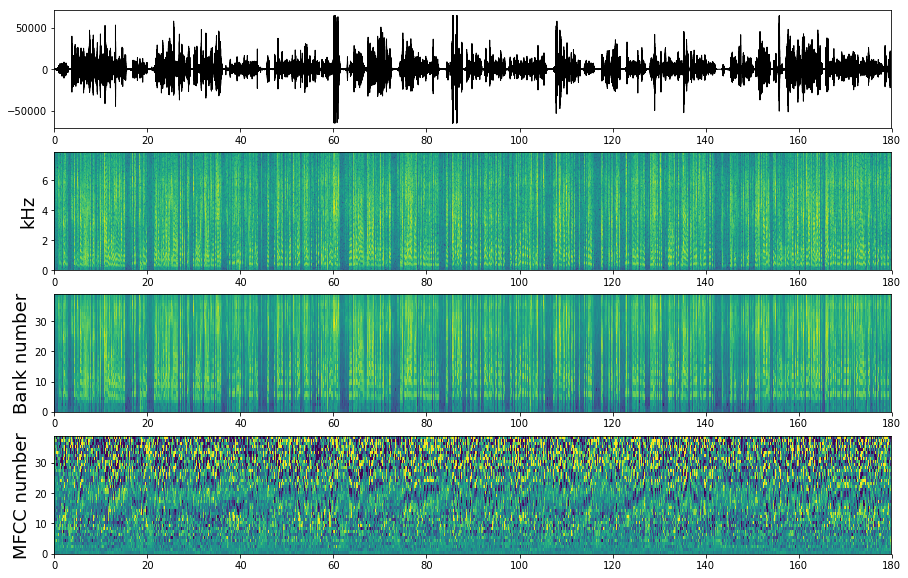

In [102]:
# Results
plt.figure(figsize=(15, 10))
plt.subplot(4,1,1)
plt.plot(np.arange(signal[:observing_time * sample_rate].size) /
         sample_rate, signal[:observing_time * sample_rate], 'k', lw=1)
plt.xlim(np.min(t), np.max(t))
plt.subplot(4,1,2)
plt.pcolor(t, freq[freqs] / 1e3, spectrogram)
plt.ylabel('kHz', fontsize=18)
plt.subplot(4,1,3)
plt.pcolor(t, np.arange(filter_banks.shape[1]), filter_banks[:,np.arange(num_ceps)].T)
plt.ylabel('Bank number', fontsize=18)
plt.subplot(4,1,4)
plt.pcolor(t, np.arange(num_ceps), mfcc.T)
plt.clim(-.2, .2)
plt.ylabel('MFCC number', fontsize=18)
plt.show()

In [103]:
# choosing coeffitients
mfcc_ = mfcc[:, 1:25]

In [104]:
# Average features clustering by GMM
x = []
for left, right in zip(pauses_idx[1,:-1], pauses_idx[0,1:]):
    x.append(np.median(mfcc_[left:right,:], axis=0))
x = np.array(x)

segments_count = pauses_idx.shape[1] - 1
segments = np.arange(segments_count) + .5

from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(x)
dictor_labels_est = gmm.predict_proba(x)[:, 0]

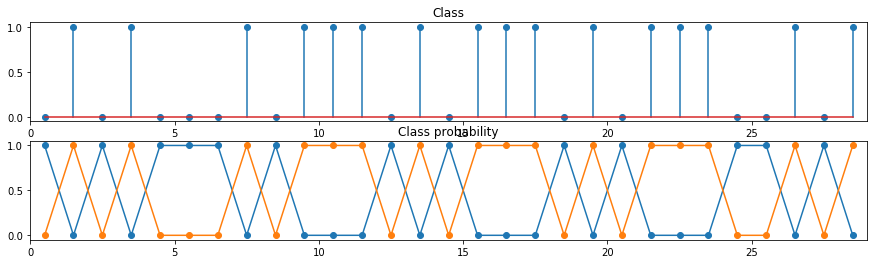

In [105]:
plt.figure(figsize=(15, 4)) 
plt.subplot(2,1,1)
plt.stem(segments, gmm.predict(x))
plt.title('Class')
plt.xlim(0, segments_count)
plt.subplot(2,1,2)
plt.plot(segments, gmm.predict_proba(x), '-o')
plt.title('Class probability')
plt.xlim(0, segments_count)
plt.show()

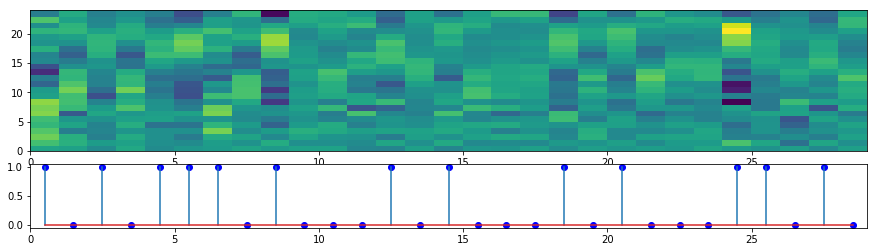

In [106]:
plt.figure(figsize=(15, 4)) 
plt.subplot(3,1,(1, 2))
plt.pcolor(np.array(x).T)
plt.subplot(3,1,3)
plt.stem(segments, dictor_labels_est, markerfmt='bo', ms=100)
plt.xlim(0, segments_count)
plt.show()

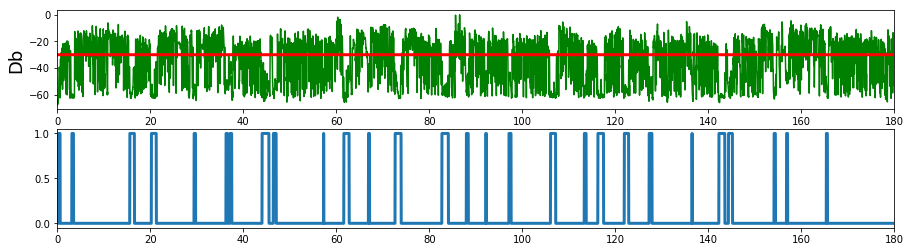

In [108]:
plt.figure(figsize=(15, 4)) 
plt.subplot(2,1,1)
plt.plot(t, average_power_db, 'g')
plt.plot(t, level * np.ones_like(time[times]), 'r', lw=3)
plt.ylabel('Db', fontsize=18)
plt.xlim(np.min(t), np.max(t))
plt.subplot(2,1,2)
plt.plot(t, pauses, lw=3)
plt.xlim(np.min(t), np.max(t))
plt.show()

In [109]:
# Main components of average feature vectors
vals, vecs = np.linalg.eig(np.cov(x.T))
vecs = np.real(vecs)

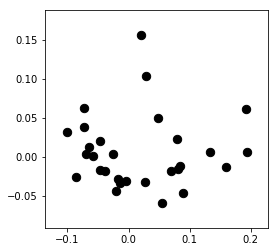

In [110]:
plt.figure(figsize=(4, 4)) 
plt.s
plt.scatter(np.dot(x, vecs[:, 0]), np.dot(x, vecs[:, 1]), c='k', s=70)
plt.show()